In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install ipython-autotime
%load_ext autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 1.3 ms (started: 2024-08-24 15:39:38 +00:00)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 24.8 s (started: 2024-08-24 15:39:38 +00:00)


In [4]:
from google.colab import files
import os
import shutil

# Copy scripts from Google Drive to Colab
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/feature_selectors.py', '/content/feature_selectors.py')
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/random_forest_classifier.py', '/content/random_forest_classifier.py')
shutil.copy('/content/drive/MyDrive/THESIS/classifiers/scripts/utils_rfe.py', '/content/utils.py')

'/content/utils.py'

time: 6.81 s (started: 2024-08-24 15:40:03 +00:00)


## Create combined CSV file

In [ ]:
import shutil
import pandas as pd

# Reading the CSV files
data_p9 = pd.read_csv('/content/drive/MyDrive/THESIS/classifiers/data/data_p9_preprocessed.csv')
data_p14 = pd.read_csv('/content/drive/MyDrive/THESIS/classifiers/data/data_p14_preprocessed.csv')

# Concatenating the two DataFrames
data_combined = pd.concat([data_p9, data_p14])

# Saving the combined data to a new CSV file in the Drive
output_path = '/content/drive/MyDrive/THESIS/classifiers/data/data_combined.csv'
data_combined.to_csv(output_path, index=False)

time: 57.2 s (started: 2024-08-21 11:21:01 +00:00)


# Error (recording) condition Random Forest classifier

As the classification using the audio source only is quite poor using the MLP still, we wish to test if using a random forest classifier would improve the performance of the classifier.

In [5]:
# Example of calling the function
DATA_FILE = '/content/drive/MyDrive/THESIS/classifiers/data/data_combined.csv'
RANDOM_STATE = 42

from random_forest_classifier import train_random_forest, evaluate_random_forest
from utils import prepare_data, plot_confusion_matrix, standardize_x_data, remove_specified_conditions
from sklearn.model_selection import train_test_split

time: 4.81 s (started: 2024-08-24 15:40:10 +00:00)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def run_rf_rfe(data_file, conditions_to_remove, modalities, num_features=5, random_state=42, test_size=0.2):
    x, y, selected_features = prepare_data(
        data_file,
        audio_source='computer',
        classify='recording_condition',
        feature_selection=7,
        algorithm='rf',
        num_features=num_features,
        modalities=modalities,
        conditions_to_remove=conditions_to_remove,
        column_name='recording_condition'
    )
    class_names = y.unique()

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=random_state)
    f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

    print("selected features: ", selected_features)
    print(f"F1 Score: {f1}")
    print(f"Classification Report:\n{class_report}")

    plot_confusion_matrix(conf_matrix, class_names=class_names)


time: 12.4 ms (started: 2024-08-24 15:40:15 +00:00)


In [14]:
from sklearn.model_selection import train_test_split

def run_rf_selectKBest(data_file,
                               audio_source='computer',
                               classify='recording_condition',
                               num_features=None,
                               modalities=None,
                               conditions_to_remove=None,
                               column_name='recording_condition',
                               random_state=42,
                               n_estimators=100):

    # Prepare data
    x, y, selected_features = prepare_data(data_file,
                                           audio_source=audio_source,
                                           classify=classify,
                                           num_features=num_features,
                                           modalities=modalities,
                                           conditions_to_remove=conditions_to_remove,
                                           column_name=column_name)

    class_names = y.unique()

    # Split data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.2,
                                                        random_state=random_state,
                                                        stratify=y)

    # Train and evaluate the model
    pipeline = train_random_forest(x_train, y_train,
                                   n_estimators=n_estimators,
                                   random_state=random_state)

    f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

    # Print results
    print("Selected features: ", selected_features)
    print("F1 Score: ", f1)
    print("Classification Report:")
    print(class_report)

    # Plot the confusion matrix
    plot_confusion_matrix(conf_matrix, class_names=class_names)


time: 2.98 ms (started: 2024-08-24 15:50:06 +00:00)


# 5. Separating classification task into 4-way tasks

## Posture.

All audio features

Mean cross-validated F1 score: 0.571493262241227
selected features:  None
f1 score:  0.5766521039974034
Classification Report:
              precision    recall  f1-score   support

     correct       0.59      0.55      0.57      3641
 arched_back       0.55      0.65      0.59      4123
hunched_back       0.57      0.52      0.54      3506
    sideways       0.62      0.58      0.60      3731

    accuracy                           0.58     15001
   macro avg       0.58      0.57      0.58     15001
weighted avg       0.58      0.58      0.58     15001



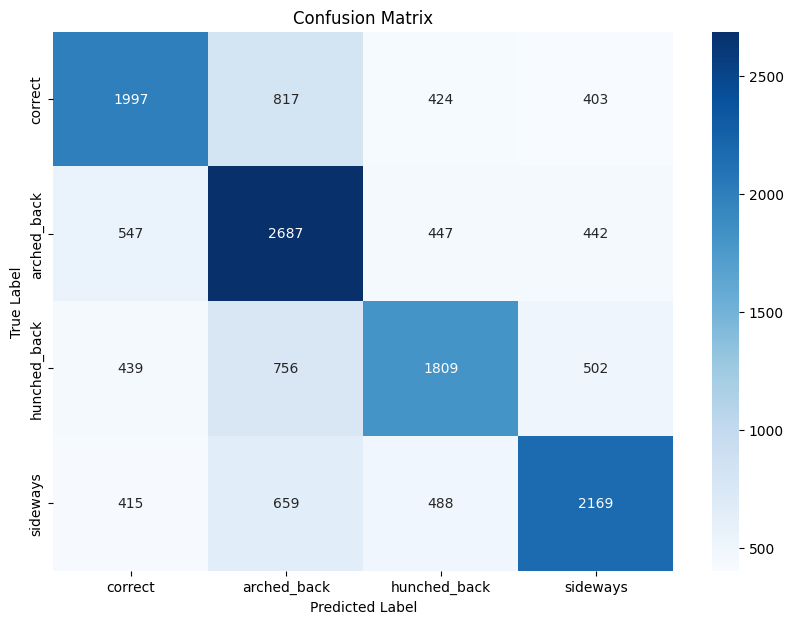

time: 15min 2s (started: 2024-08-19 15:49:02 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)


print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

RFE with 5 features

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
Mean cross-validated F1 score: 0.4878142237413307
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
F1 Score: 0.49879588346889936
Classification Report:
              precision    recall  f1-score   support

     correct       0.52      0.50      0.51      3641
 arched_back       0.49      0.55      0.52      4123
hunched_back       0.49      0.45      0.46      3506
    sideways       0.50      0.49      0.50      3731

    accuracy                           0.50     15001
   macro avg       0.50      0.50      0.50     15001
weighted avg       0.50      0.50      0.50     15001



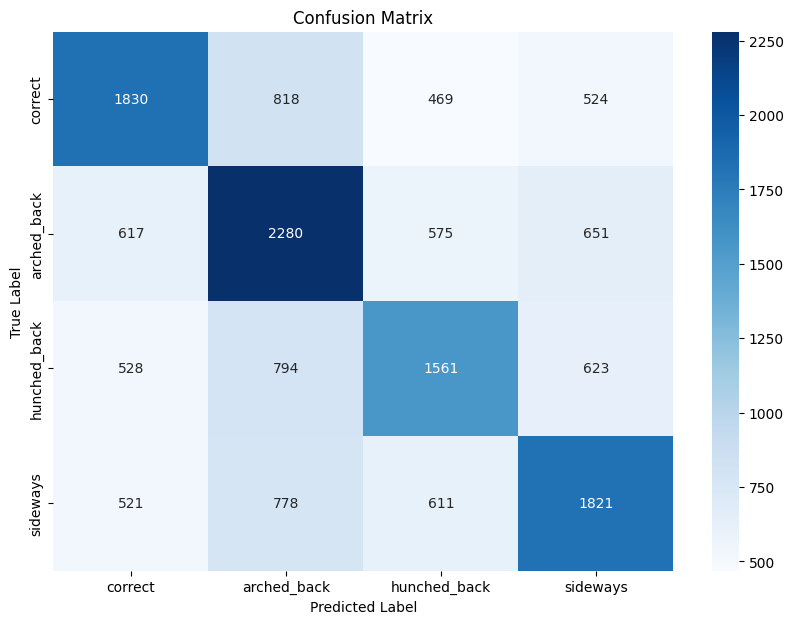

time: 36min 33s (started: 2024-08-19 16:04:04 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Audio or video, all features

Mean cross-validated F1 score: 0.9999166660371266
selected features:  None
f1 score:  1.0
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      3641
 arched_back       1.00      1.00      1.00      4123
hunched_back       1.00      1.00      1.00      3506
    sideways       1.00      1.00      1.00      3731

    accuracy                           1.00     15001
   macro avg       1.00      1.00      1.00     15001
weighted avg       1.00      1.00      1.00     15001



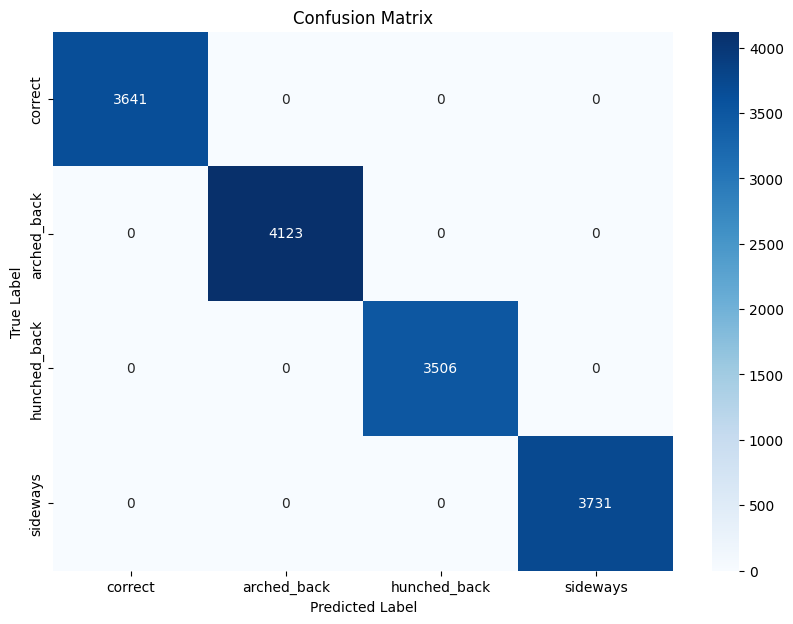

time: 9min 56s (started: 2024-08-19 16:50:24 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

Audio or video top 5

Selected features:  Index(['computer_pose_landmark_8_z', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_12_z', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_z'],
      dtype='object')
Mean cross-validated F1 score: 0.9963164775301303
selected features:  Index(['computer_pose_landmark_8_z', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_12_z', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_z'],
      dtype='object')
f1 score:  0.9973330620188381
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      3641
 arched_back       1.00      1.00      1.00      4123
hunched_back       1.00      1.00      1.00      3506
    sideways       1.00      0.99      1.00      3731

    accuracy                           1.00     15001
   macro avg       1.00      1.00      1.00     15001
weighted avg       1.00      1.00      1.00     15001



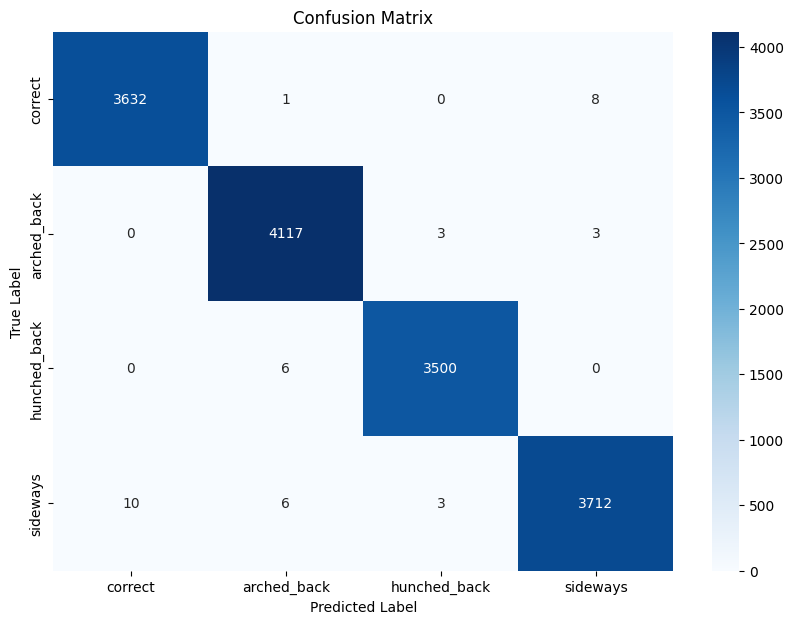

time: 3min 51s (started: 2024-08-19 17:00:26 +00:00)


In [ ]:
conditions_to_remove = ['high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

## Other error conditions

Audio only, all features

Mean cross-validated F1 score: 0.5912772715737379
selected features:  None
f1 score:  0.5943957594207191
Classification Report:
                   precision    recall  f1-score   support

          correct       0.55      0.53      0.54      3578
  chest_breathing       0.60      0.72      0.65      4123
high_articulation       0.63      0.56      0.59      3523
 low_articulation       0.62      0.56      0.58      3508

         accuracy                           0.60     14732
        macro avg       0.60      0.59      0.59     14732
     weighted avg       0.60      0.60      0.59     14732



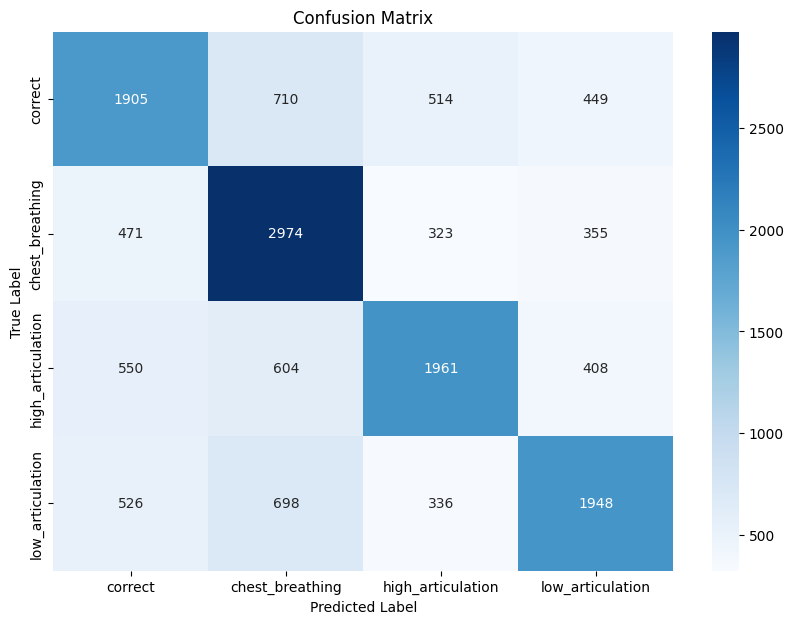

time: 14min 29s (started: 2024-08-19 17:11:01 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

RFE top 5 audio features

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.4665787088173457
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
F1 Score: 0.4705887914615606
Classification Report:
                   precision    recall  f1-score   support

          correct       0.44      0.42      0.43      3578
  chest_breathing       0.50      0.58      0.54      4123
high_articulation       0.49      0.45      0.47      3523
 low_articulation       0.46      0.43      0.44      3508

         accuracy                           0.47     14732
        macro avg       0.47      0.47      0.47     14732
     weighted avg       0.47      0.47      0.47     14732



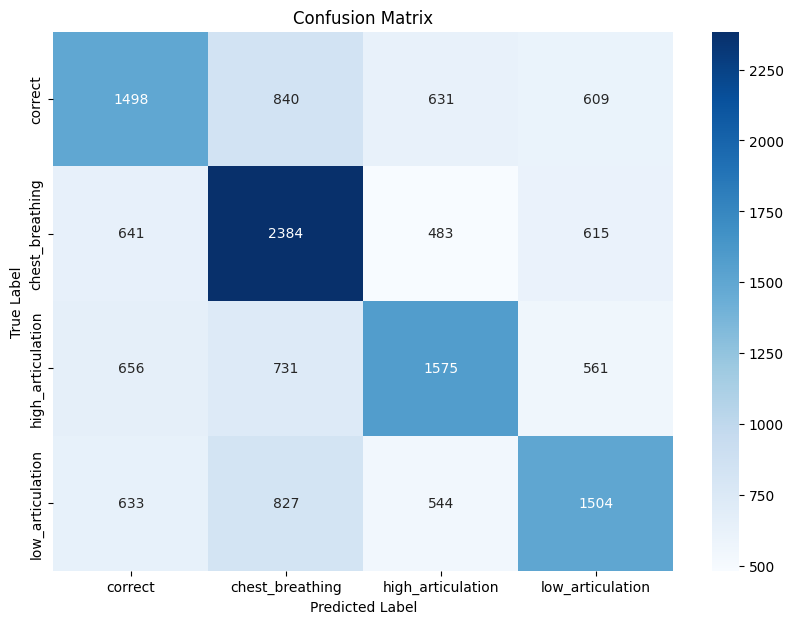

time: 36min 35s (started: 2024-08-19 17:39:38 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

Audio or video top 5

Selected features:  Index(['computer_pose_landmark_12_x', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y', 'computer_pose_landmark_14_x',
       'computer_pose_landmark_24_x'],
      dtype='object')
Mean cross-validated F1 score: 0.9965555776266912
selected features:  Index(['computer_pose_landmark_12_x', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y', 'computer_pose_landmark_14_x',
       'computer_pose_landmark_24_x'],
      dtype='object')
f1 score:  0.9978284399415812
Classification Report:
                   precision    recall  f1-score   support

          correct       0.99      1.00      1.00      3578
  chest_breathing       1.00      1.00      1.00      4123
high_articulation       1.00      1.00      1.00      3523
 low_articulation       1.00      1.00      1.00      3508

         accuracy                           1.00     14732
        macro avg       1.00      1.00      1.00     14732
     weighted avg       1.00      1.00      

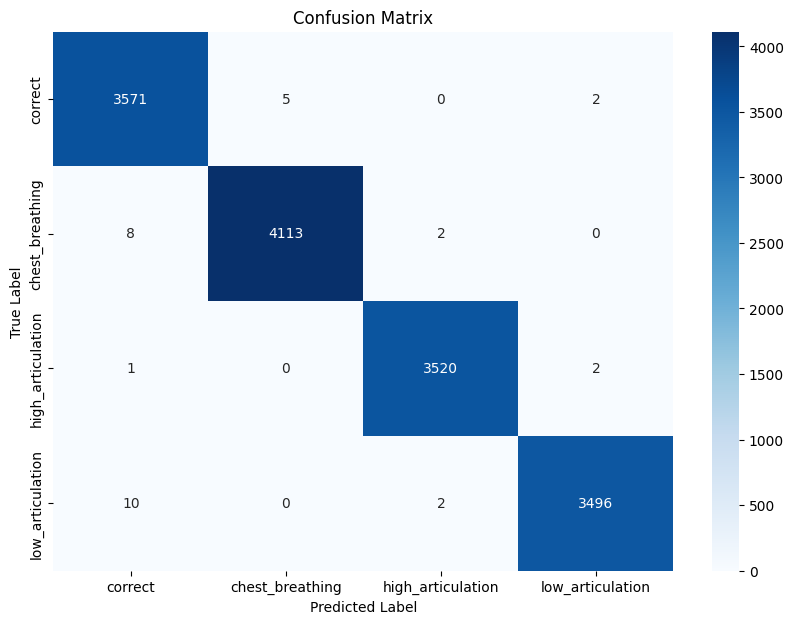

time: 4min 6s (started: 2024-08-19 18:16:13 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

Audio or Video, all features

Mean cross-validated F1 score: 0.9998642439300071
selected features:  None
f1 score:  0.9995247862285878
Classification Report:
                   precision    recall  f1-score   support

          correct       1.00      1.00      1.00      3578
  chest_breathing       1.00      1.00      1.00      4123
high_articulation       1.00      1.00      1.00      3523
 low_articulation       1.00      1.00      1.00      3508

         accuracy                           1.00     14732
        macro avg       1.00      1.00      1.00     14732
     weighted avg       1.00      1.00      1.00     14732



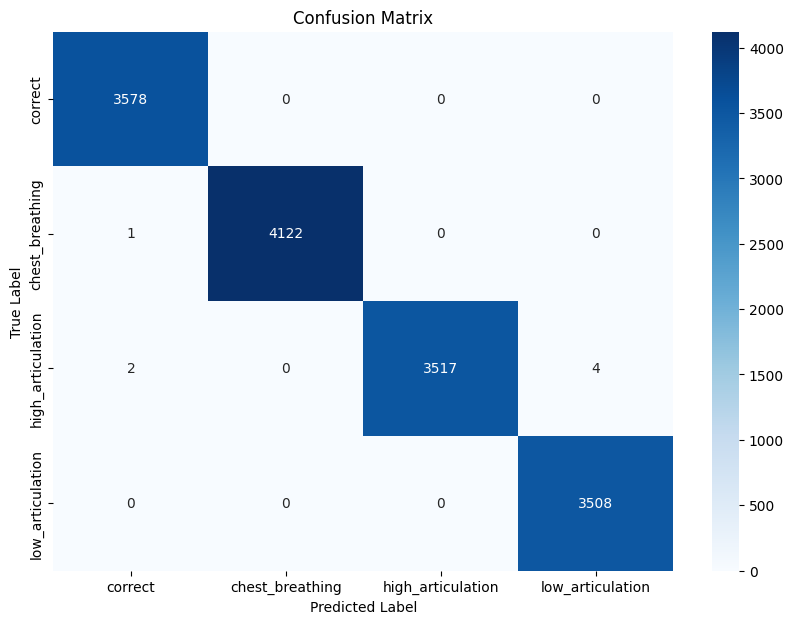

time: 11min (started: 2024-08-19 18:20:20 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways']
modalities = ['audio', 'video']

#prepare data
x, y, selected_features = prepare_data(DATA_FILE, audio_source='computer', classify='recording_condition', modalities=modalities, conditions_to_remove=conditions_to_remove, column_name='recording_condition')

class_names=y.unique()

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

#train and evaluate the model
pipeline = train_random_forest(x_train, y_train, n_estimators=100, random_state=RANDOM_STATE)
f1, class_report, conf_matrix = evaluate_random_forest(pipeline, x_test, y_test, class_names)

print("selected features: ", selected_features)
print("f1 score: ", f1)
print("Classification Report:")
print(class_report)

plot_confusion_matrix(conf_matrix, class_names=class_names)

# 2-way classifiers for audio only

## Hunched Back

Selected features:  Index(['computer_pitch', 'computer_spec_spread', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
Mean cross-validated F1 score: 0.6975960761153621
selected features:  Index(['computer_pitch', 'computer_spec_spread', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
F1 Score: 0.7111120733662682
Classification Report:
              precision    recall  f1-score   support

     correct       0.71      0.79      0.75      4123
hunched_back       0.72      0.63      0.67      3506

    accuracy                           0.71      7629
   macro avg       0.71      0.71      0.71      7629
weighted avg       0.71      0.71      0.71      7629



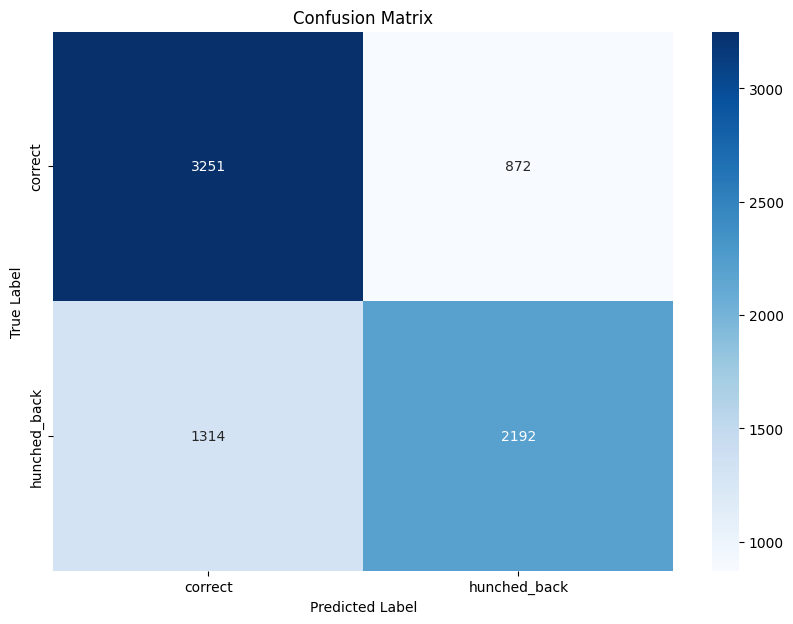

time: 16min 36s (started: 2024-08-19 18:31:21 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video

Selected features:  Index(['computer_pose_landmark_8_z', 'computer_pose_landmark_9_z',
       'computer_pose_landmark_12_z', 'computer_pose_landmark_13_z',
       'computer_pose_landmark_14_z'],
      dtype='object')
Mean cross-validated F1 score: 0.9885921757997854
Selected features:  Index(['computer_pose_landmark_8_z', 'computer_pose_landmark_9_z',
       'computer_pose_landmark_12_z', 'computer_pose_landmark_13_z',
       'computer_pose_landmark_14_z'],
      dtype='object')
F1 Score:  0.9900364903734657
Classification Report:
              precision    recall  f1-score   support

     correct       0.99      0.99      0.99      4123
hunched_back       0.99      0.99      0.99      3506

    accuracy                           0.99      7629
   macro avg       0.99      0.99      0.99      7629
weighted avg       0.99      0.99      0.99      7629



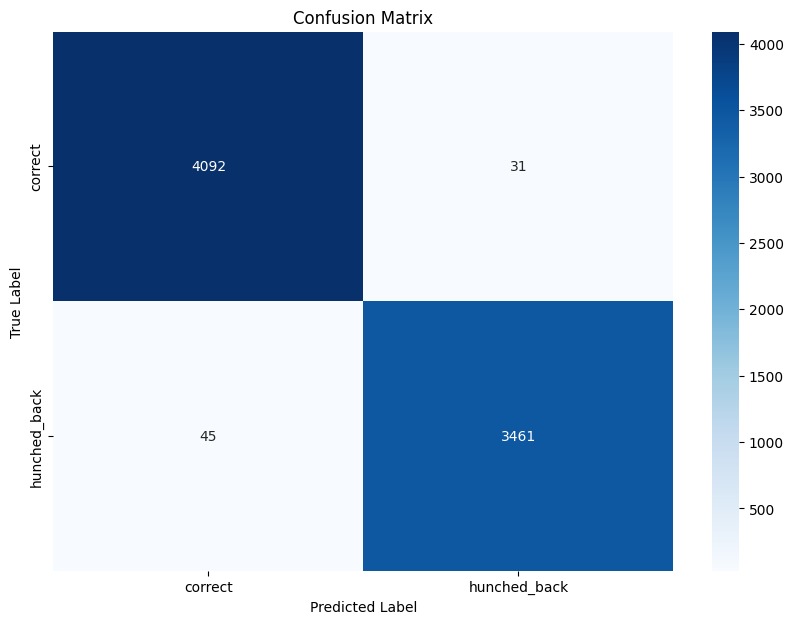

time: 1min 32s (started: 2024-08-24 15:46:30 +00:00)


In [13]:
conditions_to_remove = ['arched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)

#### Biosignals

Mean cross-validated F1 score: 0.5707115022070595
Selected features:  None
F1 Score:  0.5702482845663336
Classification Report:
              precision    recall  f1-score   support

     correct       0.60      0.63      0.61      4123
hunched_back       0.54      0.50      0.52      3506

    accuracy                           0.57      7629
   macro avg       0.57      0.57      0.57      7629
weighted avg       0.57      0.57      0.57      7629



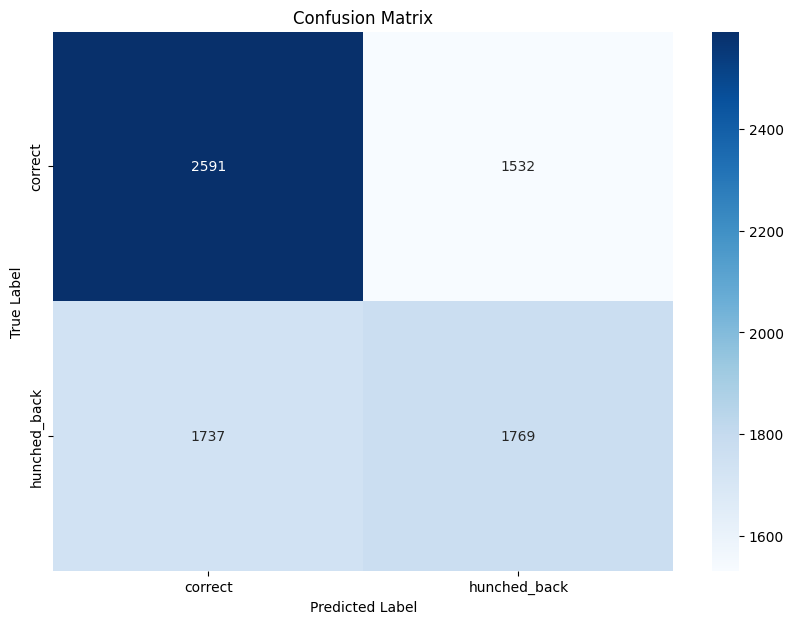

time: 1min 32s (started: 2024-08-24 15:50:24 +00:00)


In [15]:
conditions_to_remove = ['arched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE, modalities=modalities, conditions_to_remove=conditions_to_remove)

## Arched Back

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
Mean cross-validated F1 score: 0.6925880194090986
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_tristimulus2',
       'computer_mfcc_1', 'computer_mfcc_3'],
      dtype='object')
F1 Score: 0.7115235607563766
Classification Report:
              precision    recall  f1-score   support

     correct       0.71      0.65      0.68      3641
 arched_back       0.71      0.77      0.74      4123

    accuracy                           0.71      7764
   macro avg       0.71      0.71      0.71      7764
weighted avg       0.71      0.71      0.71      7764



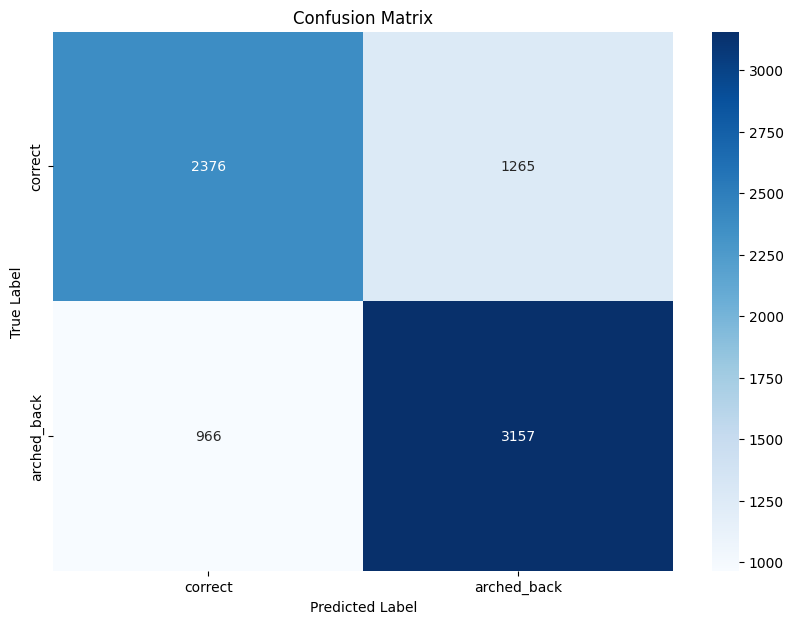

time: 18min 19s (started: 2024-08-19 18:47:59 +00:00)


In [ ]:
conditions_to_remove = ['hunched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video

Selected features:  Index(['computer_pose_landmark_12_y', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_y', 'computer_face_landmark_4_x',
       'computer_face_landmark_5_x'],
      dtype='object')
Mean cross-validated F1 score: 1.0
Selected features:  Index(['computer_pose_landmark_12_y', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_y', 'computer_face_landmark_4_x',
       'computer_face_landmark_5_x'],
      dtype='object')
F1 Score:  1.0
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      3641
 arched_back       1.00      1.00      1.00      4123

    accuracy                           1.00      7764
   macro avg       1.00      1.00      1.00      7764
weighted avg       1.00      1.00      1.00      7764



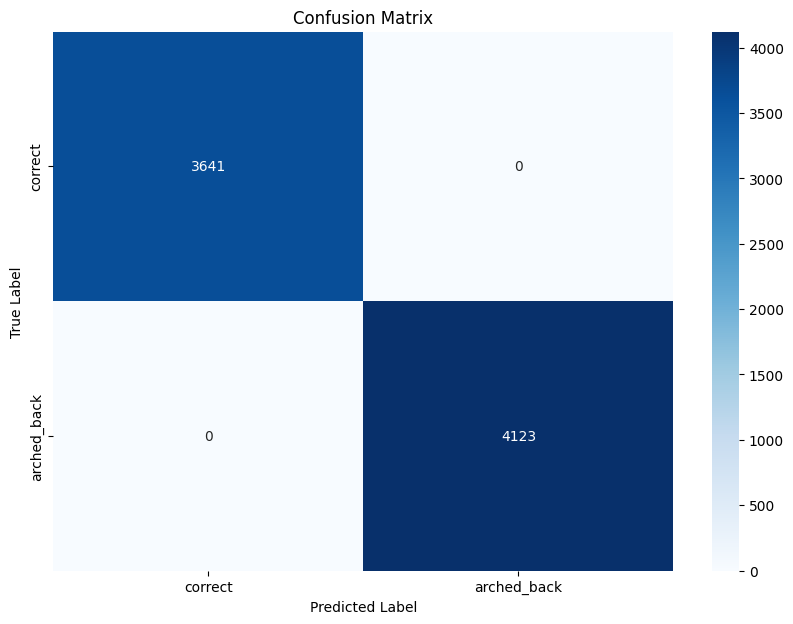

time: 49.6 s (started: 2024-08-24 15:51:57 +00:00)


In [16]:
conditions_to_remove = ['hunched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)

#### Biosignal

Mean cross-validated F1 score: 0.5344720632843871
Selected features:  None
F1 Score:  0.5487575307503669
Classification Report:
              precision    recall  f1-score   support

     correct       0.52      0.50      0.51      3641
 arched_back       0.57      0.59      0.58      4123

    accuracy                           0.55      7764
   macro avg       0.55      0.55      0.55      7764
weighted avg       0.55      0.55      0.55      7764



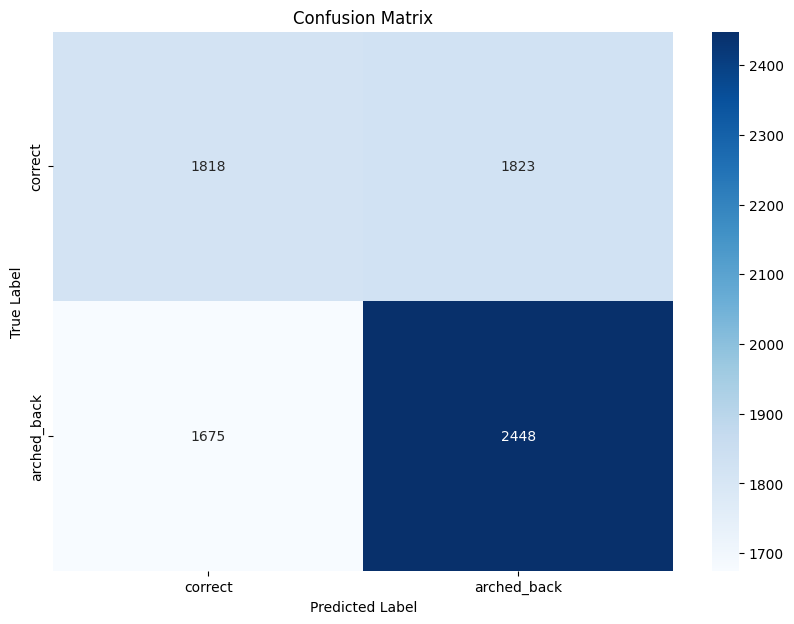

time: 1min 38s (started: 2024-08-24 15:52:47 +00:00)


In [17]:
conditions_to_remove = ['hunched_back', 'sideways', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE, modalities=modalities, conditions_to_remove=conditions_to_remove)

## Sideways

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_6'],
      dtype='object')
Mean cross-validated F1 score: 0.6849353843645123
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_6'],
      dtype='object')
F1 Score: 0.6848672923361067
Classification Report:
              precision    recall  f1-score   support

     correct       0.69      0.73      0.71      4123
    sideways       0.68      0.63      0.66      3731

    accuracy                           0.69      7854
   macro avg       0.69      0.68      0.68      7854
weighted avg       0.69      0.69      0.68      7854



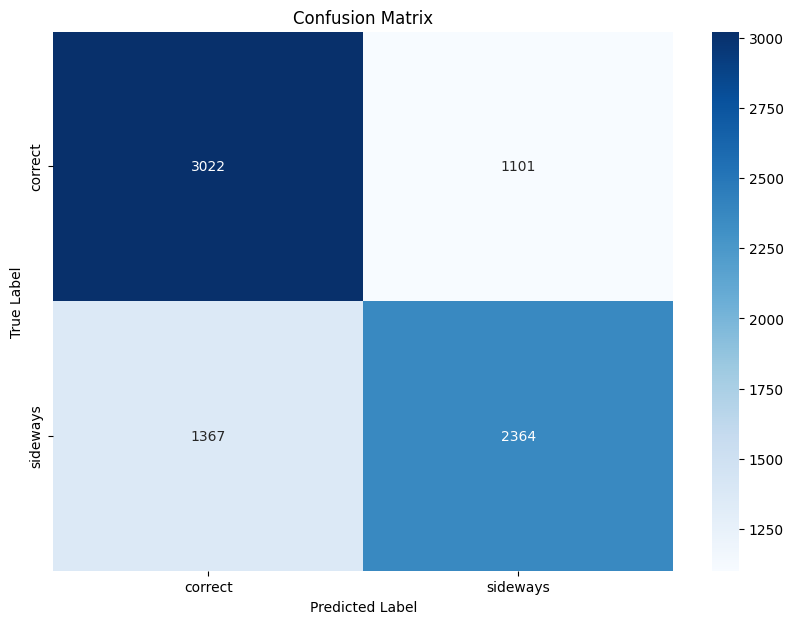

time: 17min 58s (started: 2024-08-19 19:06:18 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video


Selected features:  Index(['computer_pose_landmark_1_y', 'computer_pose_landmark_10_y',
       'computer_pose_landmark_11_y', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y'],
      dtype='object')
Mean cross-validated F1 score: 0.9993314558936065
Selected features:  Index(['computer_pose_landmark_1_y', 'computer_pose_landmark_10_y',
       'computer_pose_landmark_11_y', 'computer_pose_landmark_12_y',
       'computer_pose_landmark_13_y'],
      dtype='object')
F1 Score:  0.9994907053730583
Classification Report:
              precision    recall  f1-score   support

     correct       1.00      1.00      1.00      4123
    sideways       1.00      1.00      1.00      3731

    accuracy                           1.00      7854
   macro avg       1.00      1.00      1.00      7854
weighted avg       1.00      1.00      1.00      7854



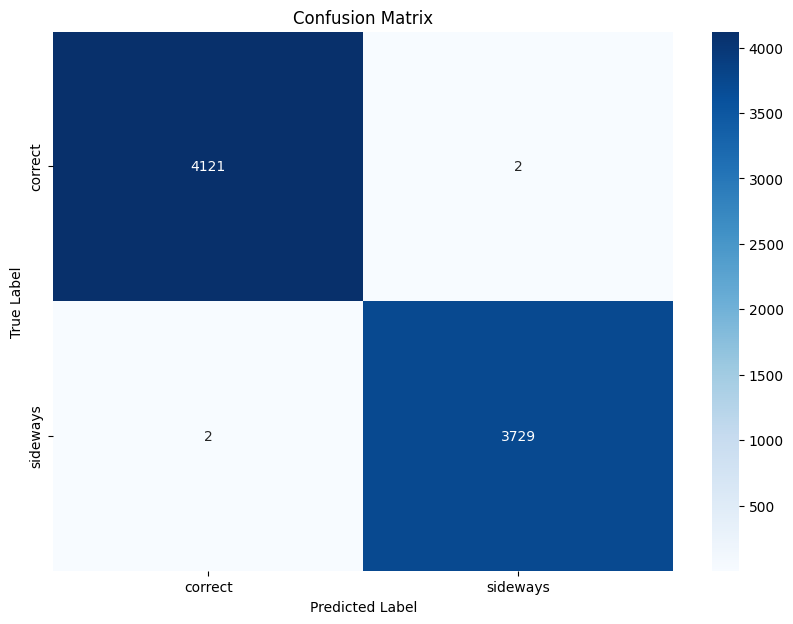

time: 1min 18s (started: 2024-08-24 15:54:25 +00:00)


In [18]:
conditions_to_remove = ['arched_back', 'hunched_back', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)

#### Biosignals

Mean cross-validated F1 score: 0.5321535631618344
Selected features:  None
F1 Score:  0.5404763161378701
Classification Report:
              precision    recall  f1-score   support

     correct       0.56      0.58      0.57      4123
    sideways       0.52      0.50      0.51      3731

    accuracy                           0.54      7854
   macro avg       0.54      0.54      0.54      7854
weighted avg       0.54      0.54      0.54      7854



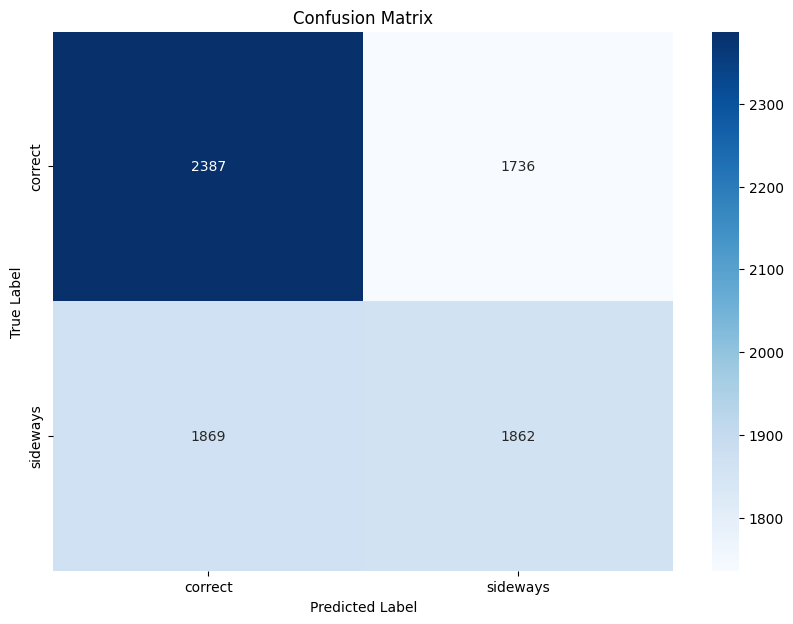

time: 1min 40s (started: 2024-08-24 15:55:44 +00:00)


In [19]:
conditions_to_remove = ['arched_back', 'hunched_back', 'high_articulation', 'low_articulation', 'chest_breathing']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE, modalities=modalities, conditions_to_remove=conditions_to_remove)

## High articulation

Selected features:  Index(['computer_pitch', 'computer_mfcc_1', 'computer_mfcc_3',
       'computer_mfcc_4', 'computer_mfcc_5'],
      dtype='object')
Mean cross-validated F1 score: 0.7215427428069
selected features:  Index(['computer_pitch', 'computer_mfcc_1', 'computer_mfcc_3',
       'computer_mfcc_4', 'computer_mfcc_5'],
      dtype='object')
F1 Score: 0.7204396527102843
Classification Report:
                   precision    recall  f1-score   support

          correct       0.72      0.79      0.75      4123
high_articulation       0.72      0.64      0.68      3523

         accuracy                           0.72      7646
        macro avg       0.72      0.72      0.72      7646
     weighted avg       0.72      0.72      0.72      7646



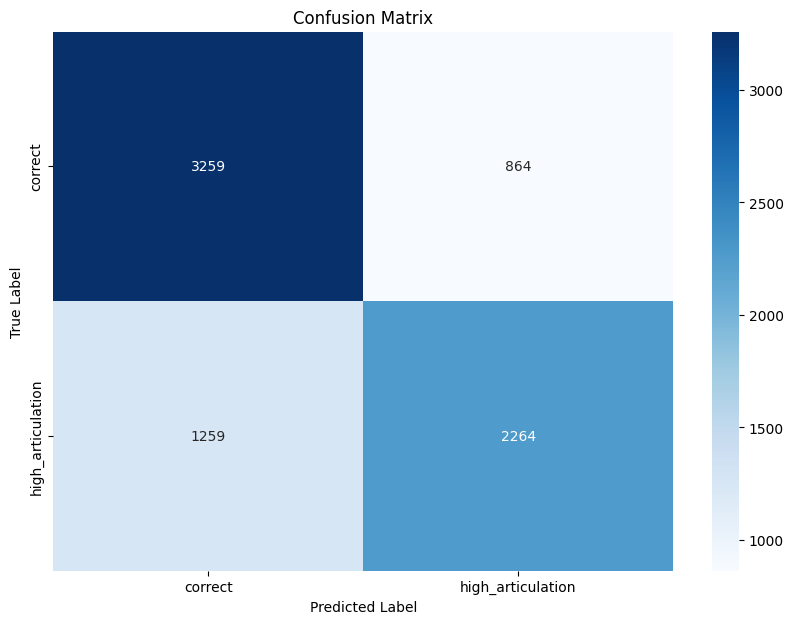

time: 16min 45s (started: 2024-08-19 21:05:51 +00:00)


In [ ]:
modalities = ['audio']
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'low_articulation', 'chest_breathing']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video

Selected features:  Index(['computer_pose_landmark_12_y', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_y', 'computer_face_landmark_3_x',
       'computer_face_landmark_4_x'],
      dtype='object')
Mean cross-validated F1 score: 0.9999672980401337
Selected features:  Index(['computer_pose_landmark_12_y', 'computer_pose_landmark_13_y',
       'computer_pose_landmark_14_y', 'computer_face_landmark_3_x',
       'computer_face_landmark_4_x'],
      dtype='object')
F1 Score:  1.0
Classification Report:
                   precision    recall  f1-score   support

          correct       1.00      1.00      1.00      4123
high_articulation       1.00      1.00      1.00      3523

         accuracy                           1.00      7646
        macro avg       1.00      1.00      1.00      7646
     weighted avg       1.00      1.00      1.00      7646



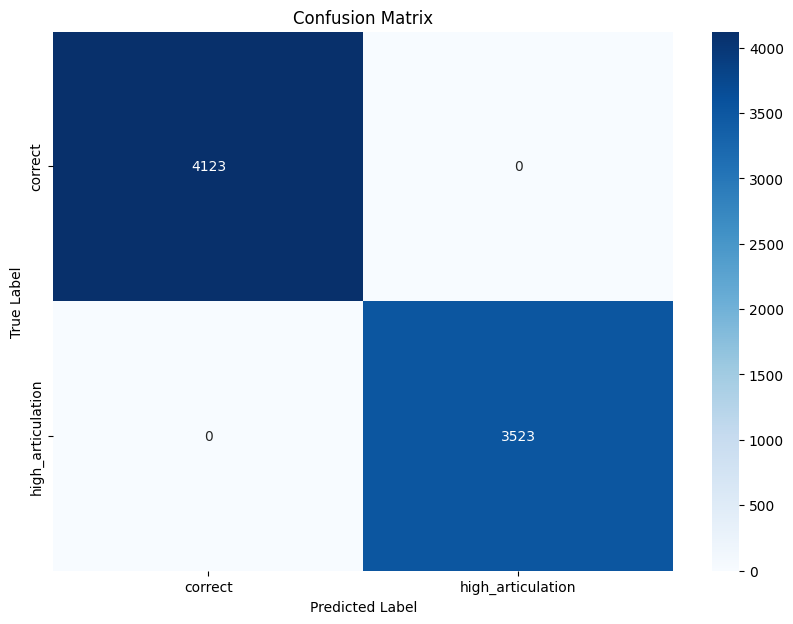

time: 42.8 s (started: 2024-08-24 15:57:24 +00:00)


In [20]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'low_articulation', 'chest_breathing']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)

#### Biosignals

Mean cross-validated F1 score: 0.640629445343154
Selected features:  None
F1 Score:  0.6428538998201061
Classification Report:
                   precision    recall  f1-score   support

          correct       0.65      0.73      0.69      4123
high_articulation       0.63      0.55      0.59      3523

         accuracy                           0.65      7646
        macro avg       0.64      0.64      0.64      7646
     weighted avg       0.64      0.65      0.64      7646



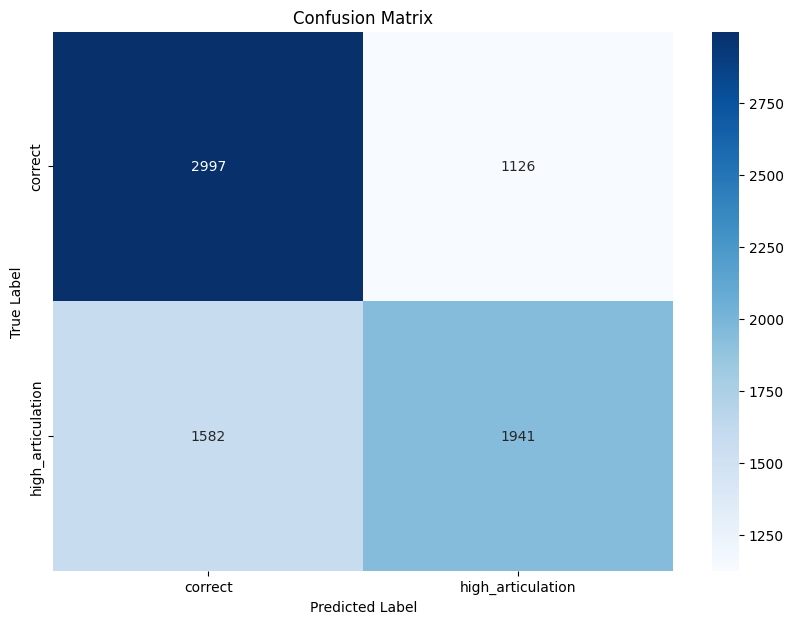

time: 1min 27s (started: 2024-08-24 15:58:22 +00:00)


In [22]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'low_articulation', 'chest_breathing']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE, modalities=modalities, conditions_to_remove=conditions_to_remove)

## Low articulation

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7084017121438844
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
F1 Score: 0.7097683022008128
Classification Report:
                  precision    recall  f1-score   support

         correct       0.72      0.77      0.74      4123
low_articulation       0.70      0.65      0.67      3508

        accuracy                           0.71      7631
       macro avg       0.71      0.71      0.71      7631
    weighted avg       0.71      0.71      0.71      7631



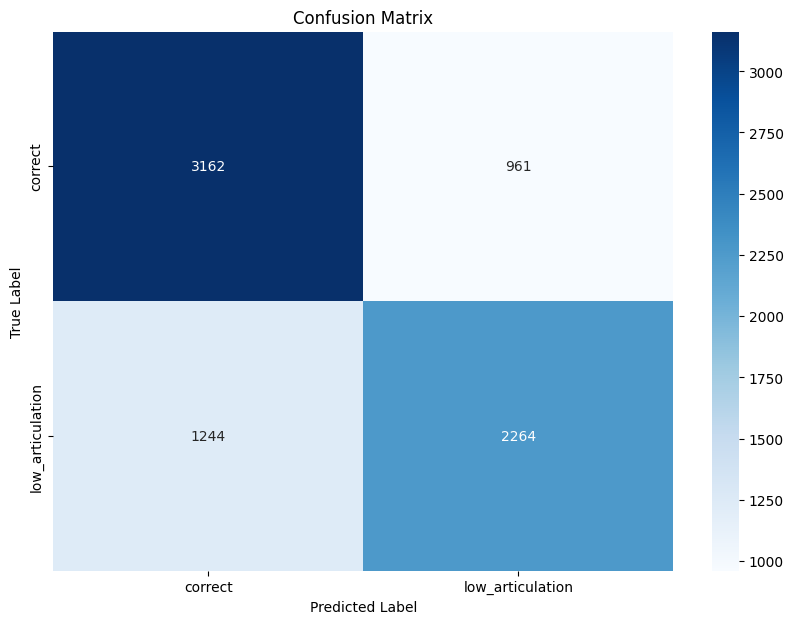

time: 15min 52s (started: 2024-08-19 21:22:36 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'chest_breathing']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video

Selected features:  Index(['computer_face_landmark_18_x', 'computer_face_landmark_19_x',
       'computer_face_landmark_23_x', 'computer_face_landmark_24_x',
       'computer_face_landmark_28_x'],
      dtype='object')
Mean cross-validated F1 score: 0.9670979471746568
Selected features:  Index(['computer_face_landmark_18_x', 'computer_face_landmark_19_x',
       'computer_face_landmark_23_x', 'computer_face_landmark_24_x',
       'computer_face_landmark_28_x'],
      dtype='object')
F1 Score:  0.9689249863684268
Classification Report:
                  precision    recall  f1-score   support

         correct       0.97      0.98      0.97      4123
low_articulation       0.97      0.96      0.97      3508

        accuracy                           0.97      7631
       macro avg       0.97      0.97      0.97      7631
    weighted avg       0.97      0.97      0.97      7631



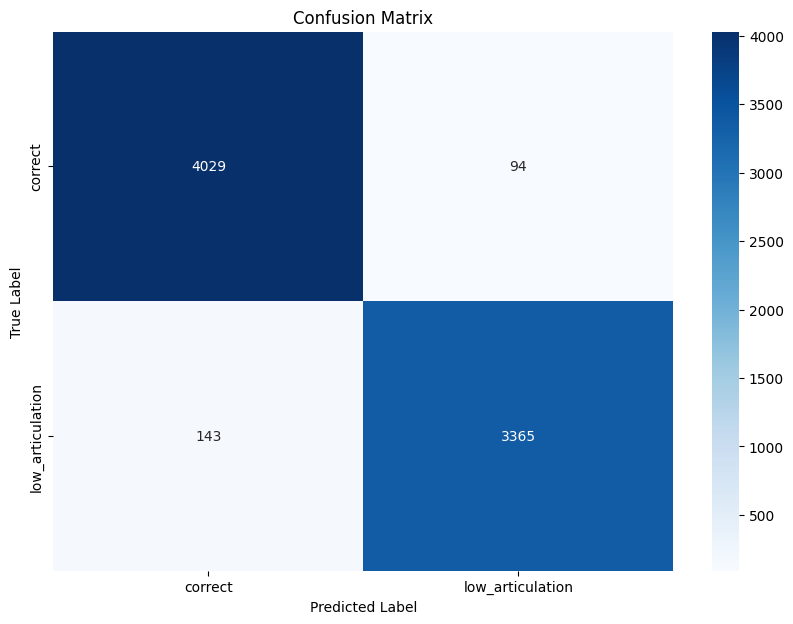

time: 32.3 s (started: 2024-08-24 15:59:49 +00:00)


In [23]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'chest_breathing']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)

#### Biosignals

Mean cross-validated F1 score: 0.557991391098196
Selected features:  None
F1 Score:  0.5542357291057841
Classification Report:
                  precision    recall  f1-score   support

         correct       0.58      0.63      0.61      4123
low_articulation       0.52      0.47      0.49      3508

        accuracy                           0.56      7631
       macro avg       0.55      0.55      0.55      7631
    weighted avg       0.55      0.56      0.55      7631



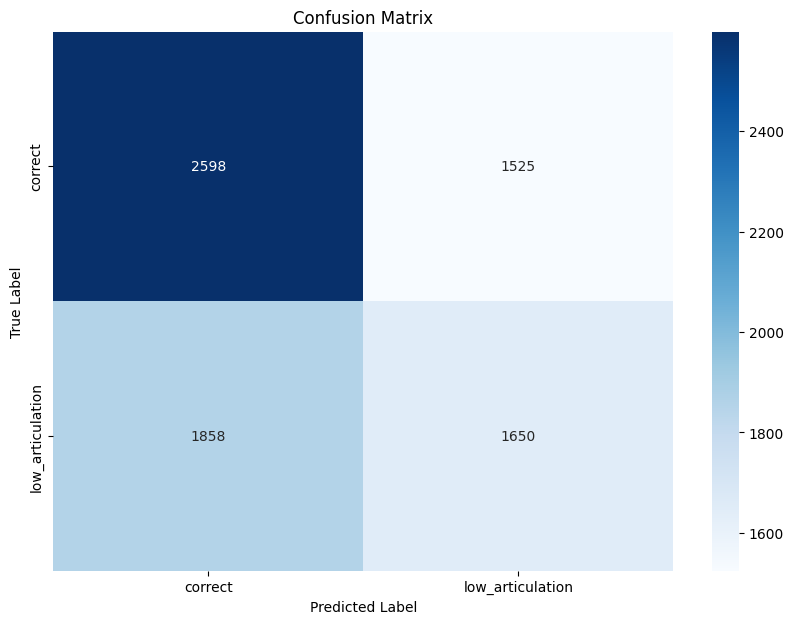

time: 1min 39s (started: 2024-08-24 16:00:22 +00:00)


In [24]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'chest_breathing']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE, modalities=modalities, conditions_to_remove=conditions_to_remove)

## Chest Breathing

Selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
Mean cross-validated F1 score: 0.7025661207222185
selected features:  Index(['computer_pitch', 'computer_rms_energy', 'computer_mfcc_1',
       'computer_mfcc_3', 'computer_mfcc_4'],
      dtype='object')
F1 Score: 0.7034314098028828
Classification Report:
                 precision    recall  f1-score   support

        correct       0.69      0.65      0.67      3578
chest_breathing       0.71      0.75      0.73      4123

       accuracy                           0.70      7701
      macro avg       0.70      0.70      0.70      7701
   weighted avg       0.70      0.70      0.70      7701



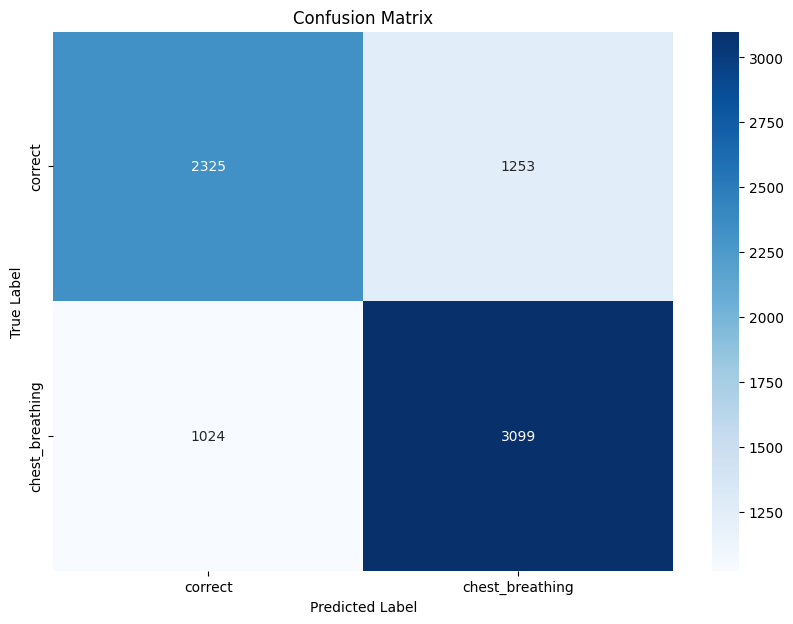

time: 17min 15s (started: 2024-08-19 21:38:28 +00:00)


In [ ]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'low_articulation']
modalities = ['audio']

run_rf_rfe(
    data_file=DATA_FILE,
    conditions_to_remove=conditions_to_remove,
    modalities=modalities,
    random_state=RANDOM_STATE,
    test_size=0.2
)

#### Video

Selected features:  Index(['computer_face_landmark_18_x', 'computer_face_landmark_19_x',
       'computer_face_landmark_20_x', 'computer_face_landmark_21_x',
       'computer_face_landmark_22_x'],
      dtype='object')
Mean cross-validated F1 score: 0.9032523565641724
Selected features:  Index(['computer_face_landmark_18_x', 'computer_face_landmark_19_x',
       'computer_face_landmark_20_x', 'computer_face_landmark_21_x',
       'computer_face_landmark_22_x'],
      dtype='object')
F1 Score:  0.8994493932990744
Classification Report:
                 precision    recall  f1-score   support

        correct       0.90      0.89      0.89      3578
chest_breathing       0.90      0.91      0.91      4123

       accuracy                           0.90      7701
      macro avg       0.90      0.90      0.90      7701
   weighted avg       0.90      0.90      0.90      7701



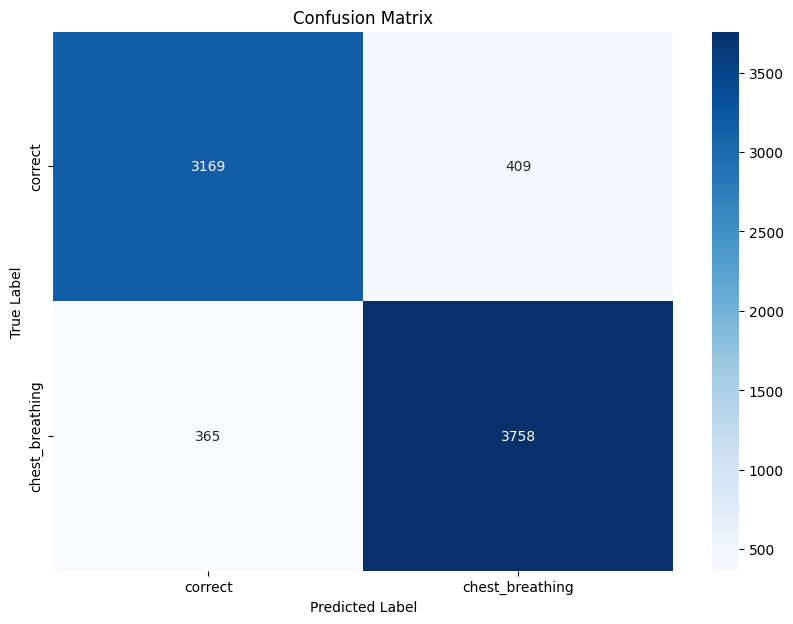

time: 31.1 s (started: 2024-08-24 16:02:02 +00:00)


In [25]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'low_articulation']
modalities = ['video']

run_rf_selectKBest(data_file=DATA_FILE, num_features=5, modalities=modalities, conditions_to_remove=conditions_to_remove)


#### Biosignals

Mean cross-validated F1 score: 0.5756886057614717
Selected features:  None
F1 Score:  0.5838499583160878
Classification Report:
                 precision    recall  f1-score   support

        correct       0.55      0.53      0.54      3578
chest_breathing       0.61      0.63      0.62      4123

       accuracy                           0.58      7701
      macro avg       0.58      0.58      0.58      7701
   weighted avg       0.58      0.58      0.58      7701



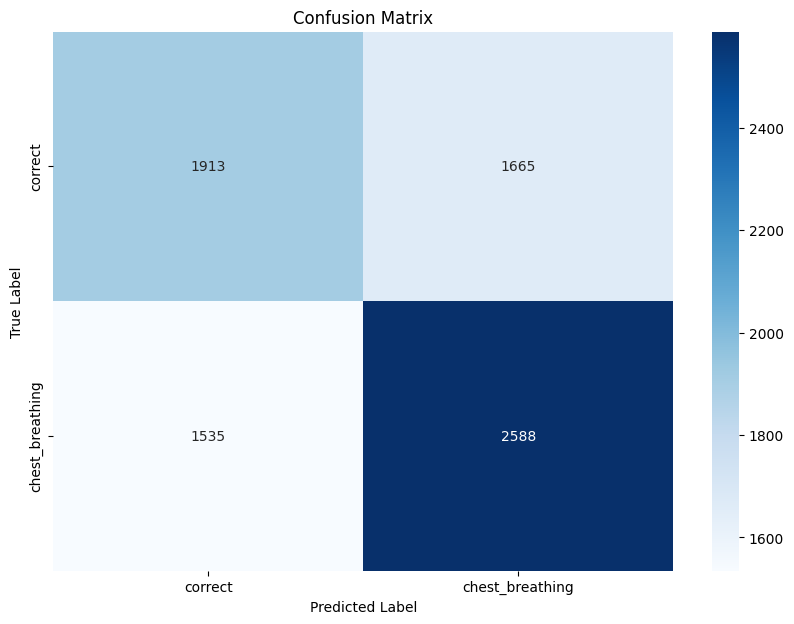

time: 1min 30s (started: 2024-08-24 16:02:33 +00:00)


In [26]:
conditions_to_remove = ['arched_back', 'hunched_back', 'sideways', 'high_articulation', 'low_articulation']
modalities = ['biosignals']

run_rf_selectKBest(data_file=DATA_FILE,modalities=modalities, conditions_to_remove=conditions_to_remove)